In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [3]:
def read_dataframe(filename):
  df = pd.read_parquet(filename)
  df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])
  df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)
  df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
  categorical = ['PULocationID', 'DOLocationID']
  numerical = ['trip_distance']
  df[categorical] = df[categorical].astype(str)
  return df


In [4]:
# in github codespaces
# january = pd.read_parquet('/workspaces/mlops-zoomcamp-own/01-intro/hw/yellow_tripdata_2023-01.parquet')

# in colab
january = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/workspaces/mlops-zoomcamp-own/01-intro/hw/yellow_tripdata_2023-01.parquet')
january

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


## Q1

In [5]:
len(january.columns)

19

## Q2

In [6]:
january.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [7]:
df1 = january.copy()

In [8]:
df1['duration'] = (df1['tpep_dropoff_datetime'] - df1['tpep_pickup_datetime'])

In [9]:
df1['duration']

0         0 days 00:08:26
1         0 days 00:06:19
2         0 days 00:12:45
3         0 days 00:09:37
4         0 days 00:10:50
                ...      
3066761   0 days 00:13:59
3066762   0 days 00:19:27
3066763   0 days 00:24:31
3066764   0 days 00:13:00
3066765   0 days 00:14:24
Name: duration, Length: 3066766, dtype: timedelta64[us]

In [10]:
df1['duration'] = df1['duration'].apply(lambda td: td.total_seconds() / 60)


In [11]:
df1['duration']

0           8.433333
1           6.316667
2          12.750000
3           9.616667
4          10.833333
             ...    
3066761    13.983333
3066762    19.450000
3066763    24.516667
3066764    13.000000
3066765    14.400000
Name: duration, Length: 3066766, dtype: float64

In [12]:
np.std(df1['duration'])

42.59434429744777

## Q3

In [13]:
df2 = df1[(df1.duration >= 1) & (df1.duration <= 60)]
df2

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN,13.983333
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN,19.450000
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN,24.516667
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN,13.000000


In [14]:
((df1['duration'] >= 1) & (df1['duration'] <= 60)).mean()

0.9812202822125979

## Q4

In [15]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']



In [16]:
df2[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [17]:
df2[categorical] = df2[categorical].astype(str)

<ipython-input-17-98a4e7724f0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[categorical] = df2[categorical].astype(str)


In [18]:
df2 = read_dataframe('/content/drive/MyDrive/Colab Notebooks/workspaces/mlops-zoomcamp-own/01-intro/hw/yellow_tripdata_2023-01.parquet')

In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3009173 entries, 0 to 3066765
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           object        
 8   DOLocationID           object        
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            floa

In [20]:
train_dicts = df2[categorical].to_dict(orient = 'records')

In [21]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [22]:
# get a feature matrix and dimensionality of the matrix
X_train.shape[1]

515

## Q5

In [23]:
target = 'duration'


In [24]:
y_train = df2[target].values

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [26]:
y_pred = lr.predict(X_train)

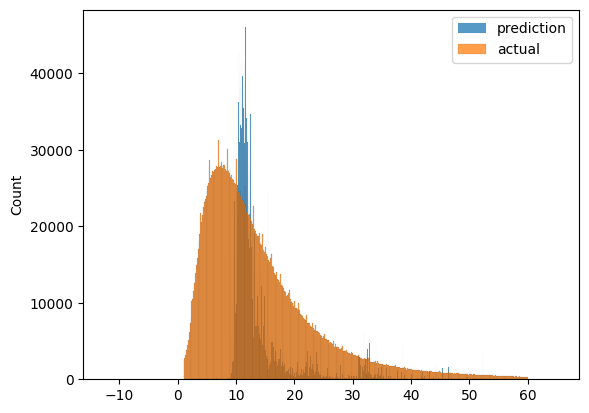

In [27]:
sns.histplot(y_pred, label = 'prediction')
sns.histplot(y_train, label = 'actual')
plt.legend()


In [28]:
mean_squared_error(y_train, y_pred, squared = False)

7.649261929771859

## Q6

In [29]:
val_df = read_dataframe('/content/drive/MyDrive/Colab Notebooks/workspaces/mlops-zoomcamp-own/01-intro/hw/yellow_tripdata_2023-02.parquet')


In [30]:
dv = DictVectorizer()
val_dicts = val_df[categorical].to_dict(orient = 'records')

In [31]:
X_val = dv.fit_transform(val_dicts)

In [32]:
y_val = val_df[target].values

In [33]:
len(dv.feature_names_)

514

In [34]:
lr = LinearRegression()
lr.fit(X_val, y_val)

LinearRegression()

In [35]:
lr.predict(X_val)
y_val_pred = lr.predict(X_val)
mean_squared_error(y_val, y_val_pred, squared = False)

7.778948573497093